In [21]:
import numpy as np

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

import positron as pt

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [22]:
# Set global seaborn theme
sns.set_theme(
        context='notebook',
        style='darkgrid',
        palette='dark',
        font='DejaVu Sans',
        color_codes=True
    )

def custom_theme(ax, title, xlabel, ylabel='Frequency'):
    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=14, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)

# Define a color for each property type
colors = {
    'building': '#3E64FF',
    'villa': '#FF6B6B',
    'unit': '#44CFCB',
    'land': '#F4A261'
}

type_order = ['unit', 'villa', 'building', 'land']  # fixed order

In [24]:
df = pd.read_parquet('./data/processed/transactions_clean.parquet')
villas = df[df['property_type'] == 'villa'].reset_index(drop=True)

areas = gpd.read_file('./data/processed/transaction_land_areas.geojson')

In [25]:
villas.head(5)

,transaction_id,procedure_id,trans_group_id,trans_group,procedure_name,instance_date,property_type_id,property_type,property_sub_type_id,property_sub_type,...,nearest_metro,nearest_mall,rooms,has_parking,procedure_area_sqm,actual_worth_aed,meter_sale_price_aed,actual_worth_usd,meter_sale_price_usd,price_to_size_ratio
0,1-11-2024-10138,11,1,sales,sell,2024-03-19,4,villa,NaN,None,...,adcb metro station,dubai mall,None,0,1305.29,5769000.0,4419.71,1557630.00,1193.3217,0.91
1,1-11-2016-12930,11,1,sales,sell,2016-11-02,4,villa,NaN,None,...,emirates towers metro station,dubai mall,None,0,390.00,2089900.0,5358.72,564273.00,1446.8544,3.71
2,1-11-2005-300028,11,1,sales,sell,2005-02-28,4,villa,NaN,None,...,trade centre metro station,dubai mall,None,0,396.09,511612.0,1291.66,138135.24,348.7482,0.88
3,1-11-2013-7839,11,1,sales,sell,2013-03-12,4,villa,NaN,None,...,emirates towers metro station,dubai mall,None,0,362.32,1500000.0,4139.99,405000.00,1117.7973,3.09
4,2-13-2016-5882,13,2,mortgages,mortgage registration,2016-08-10,4,villa,NaN,None,...,trade centre metro station,dubai mall,None,0,343.74,2760000.0,8029.32,745200.00,2167.9164,6.31


### 1.  Basic Overview

In [26]:
df = villas

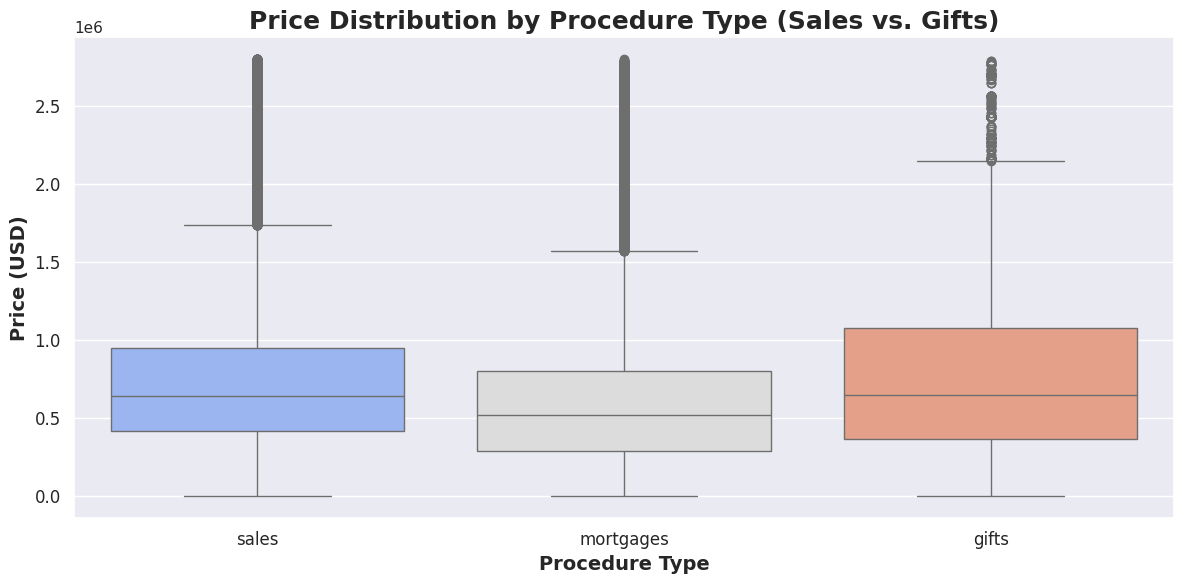

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='trans_group', y='actual_worth_usd', data=df, palette='coolwarm')

# Apply custom theme
custom_theme(plt.gca(), title='Price Distribution by Procedure Type (Sales vs. Gifts)', xlabel='Procedure Type', ylabel='Price (USD)')

# Display the plot
plt.tight_layout()
plt.show()

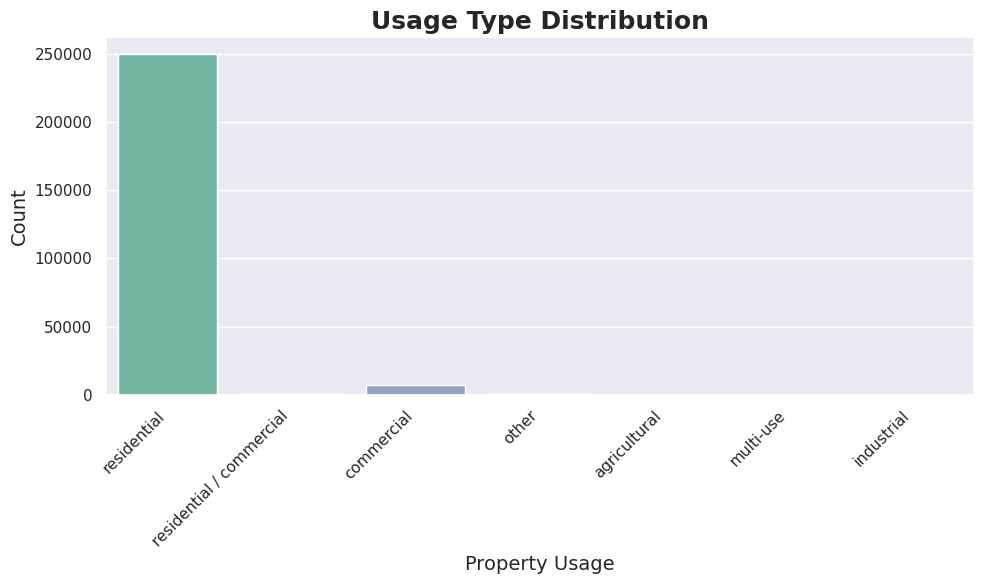

In [29]:
plt.figure(figsize=(10, 6))

# Use a nice color palette
palette = sns.color_palette("Set2")

# Create the countplot
sns.countplot(x='property_usage', data=df, palette=palette)

plt.title('Usage Type Distribution', fontsize=18, fontweight='bold')
plt.xlabel('Property Usage', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

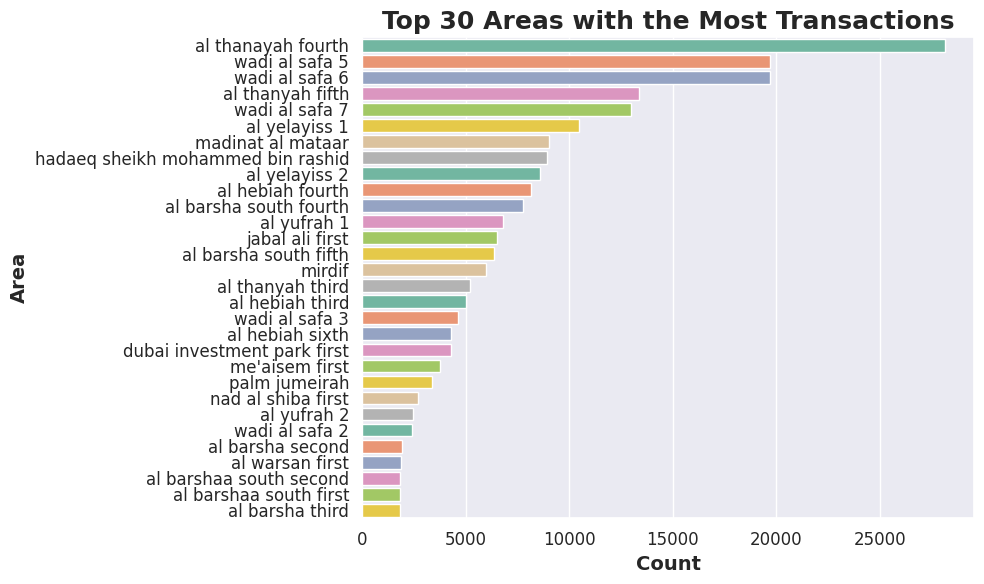

In [30]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='area_name', data=df, order=df['area_name'].value_counts().iloc[:30].index, palette='Set2')

# Custom theme
custom_theme(ax, 'Top 30 Areas with the Most Transactions', 'Count', 'Area')

# Rotate y-ticks for better readability
plt.yticks(rotation=0)

# Tighten layout
plt.tight_layout()
plt.show()

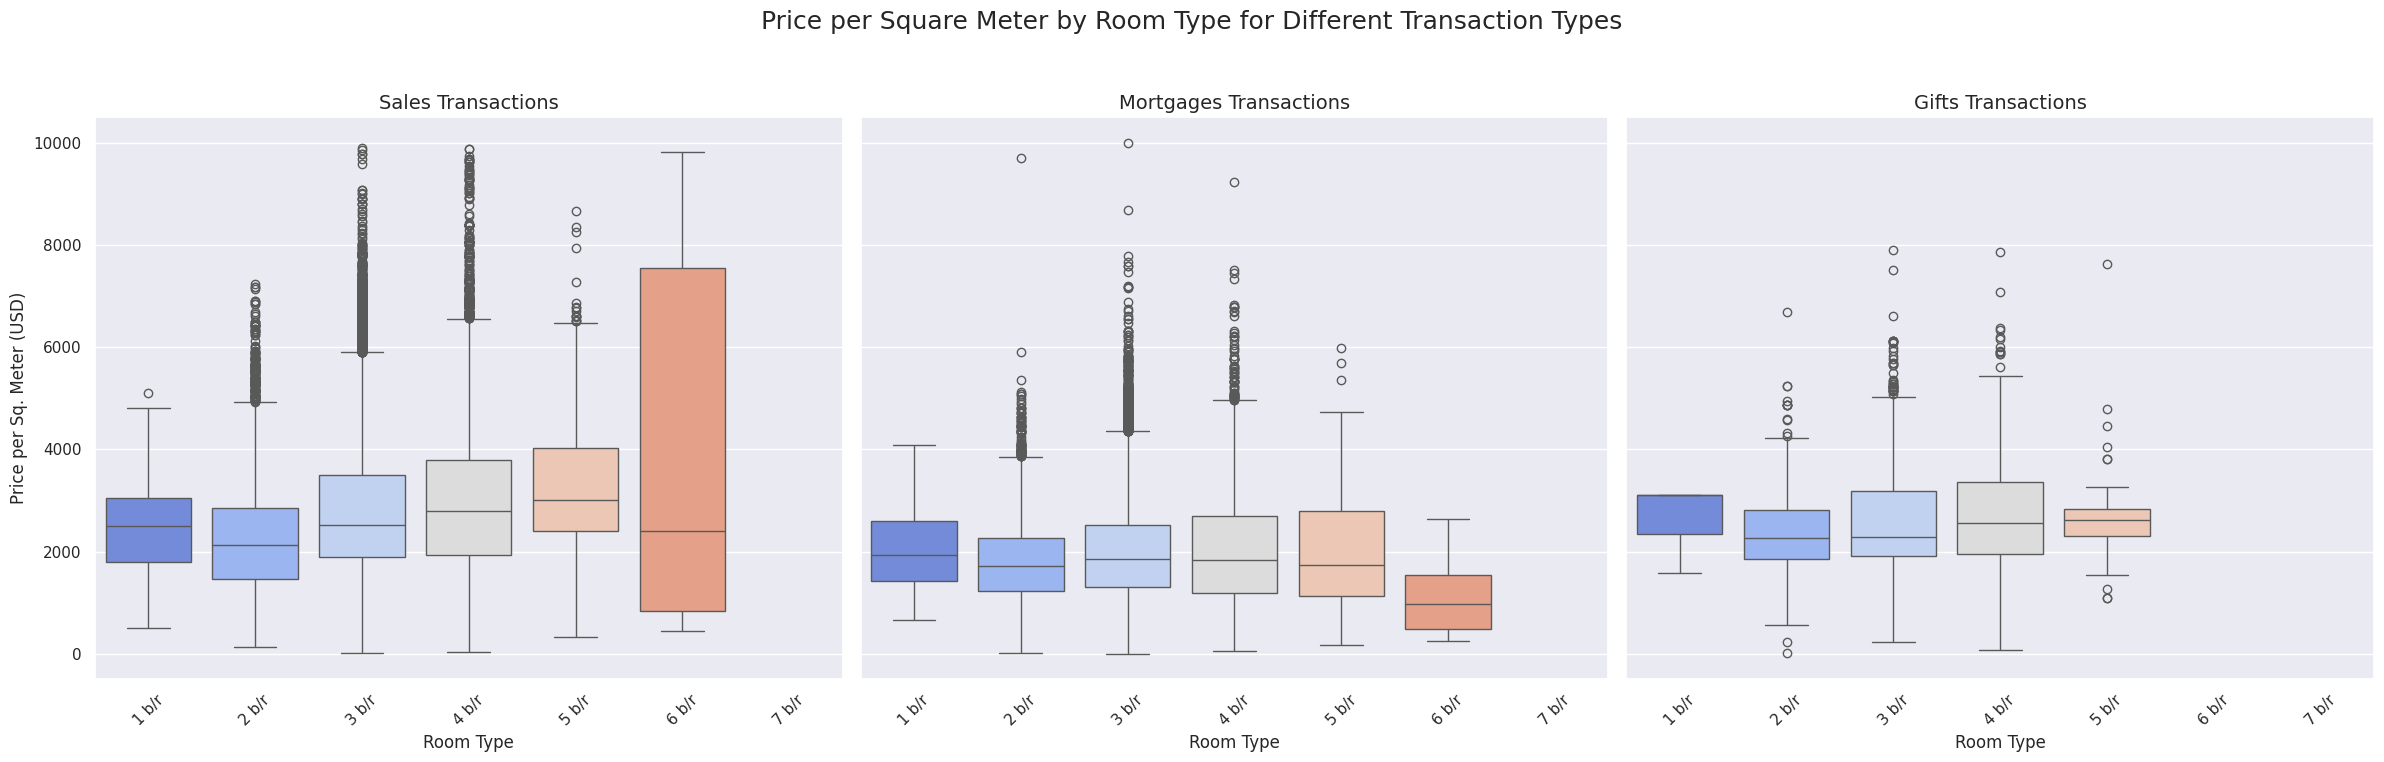

In [32]:
# Set the room order again to ensure consistency
room_order = ['1 b/r', '2 b/r', '3 b/r', '4 b/r', '5 b/r', '6 b/r', '7 b/r']
df['rooms'] = pd.Categorical(df['rooms'].str.lower(), categories=room_order, ordered=True)

# Filter dataset for usable entries
df_cleaned = df.dropna(subset=['meter_sale_price_usd', 'rooms', 'trans_group'])
df_cleaned['rooms'] = df_cleaned['rooms'].str.lower().astype(str)
df_cleaned = df_cleaned[df_cleaned['rooms'].isin(room_order)]
df_cleaned['meter_sale_price_usd'] = pd.to_numeric(df_cleaned['meter_sale_price_usd'], errors='coerce')

# Limit price for clearer visualization
price_cap = 10000
df_cleaned = df_cleaned[df_cleaned['meter_sale_price_usd'] <= price_cap]

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

# Plot for each transaction group
for ax, group in zip(axes, df_cleaned['trans_group'].unique()):
    subset = df_cleaned[df_cleaned['trans_group'] == group]
    sns.boxplot(data=subset, x='rooms', y='meter_sale_price_usd', ax=ax, palette='coolwarm', order=room_order)
    ax.set_title(f"{group.capitalize()} Transactions", fontsize=14)
    ax.set_xlabel("Room Type")
    ax.set_ylabel("Price per Sq. Meter (USD)")
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("Price per Square Meter by Room Type for Different Transaction Types", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

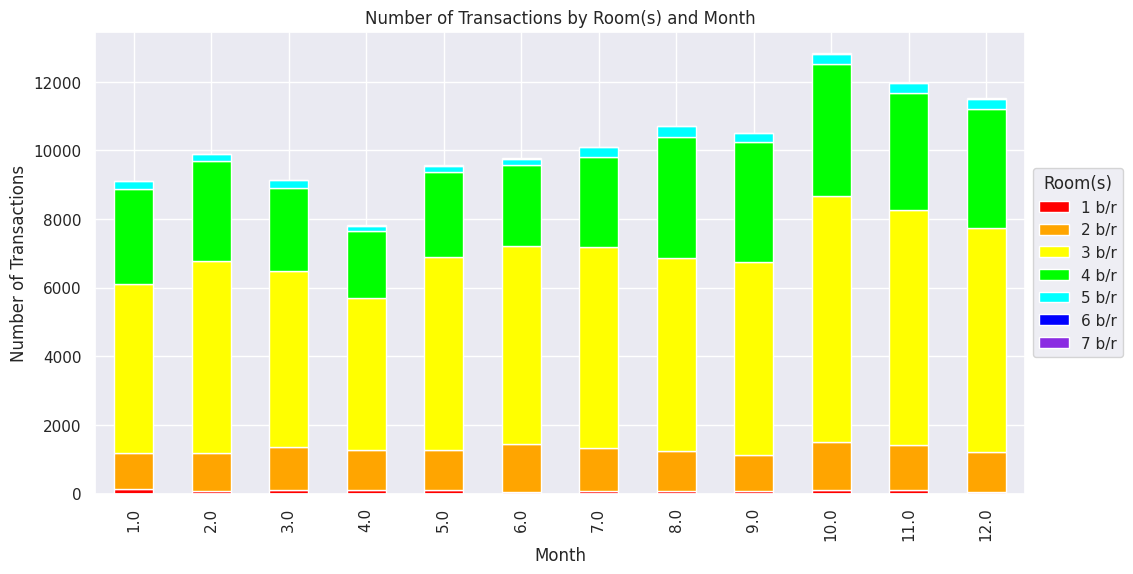

In [33]:
df['month'] = pd.to_datetime(df['instance_date']).dt.month

# Group by room and month, then count the number of transactions
room_month_counts = df.groupby(['rooms', 'month']).size().reset_index(name='counts')

# Pivot the data for the bar chart
pivot_df = room_month_counts.pivot(index='month', columns='rooms', values='counts')
# Define the custom color palette with luxury rainbow colors
colors = ['#FF0000', '#FFA500', '#FFFF00', '#00FF00', '#00FFFF', '#0000FF', '#8A2BE2', '#4B0082', '#FF00FF', '#FF1493']

# Plot the bar chart with the custom color palette
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)
plt.title('Number of Transactions by Room(s) and Month')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')

# Place the legend outside the plot
plt.legend(title='Room(s)', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

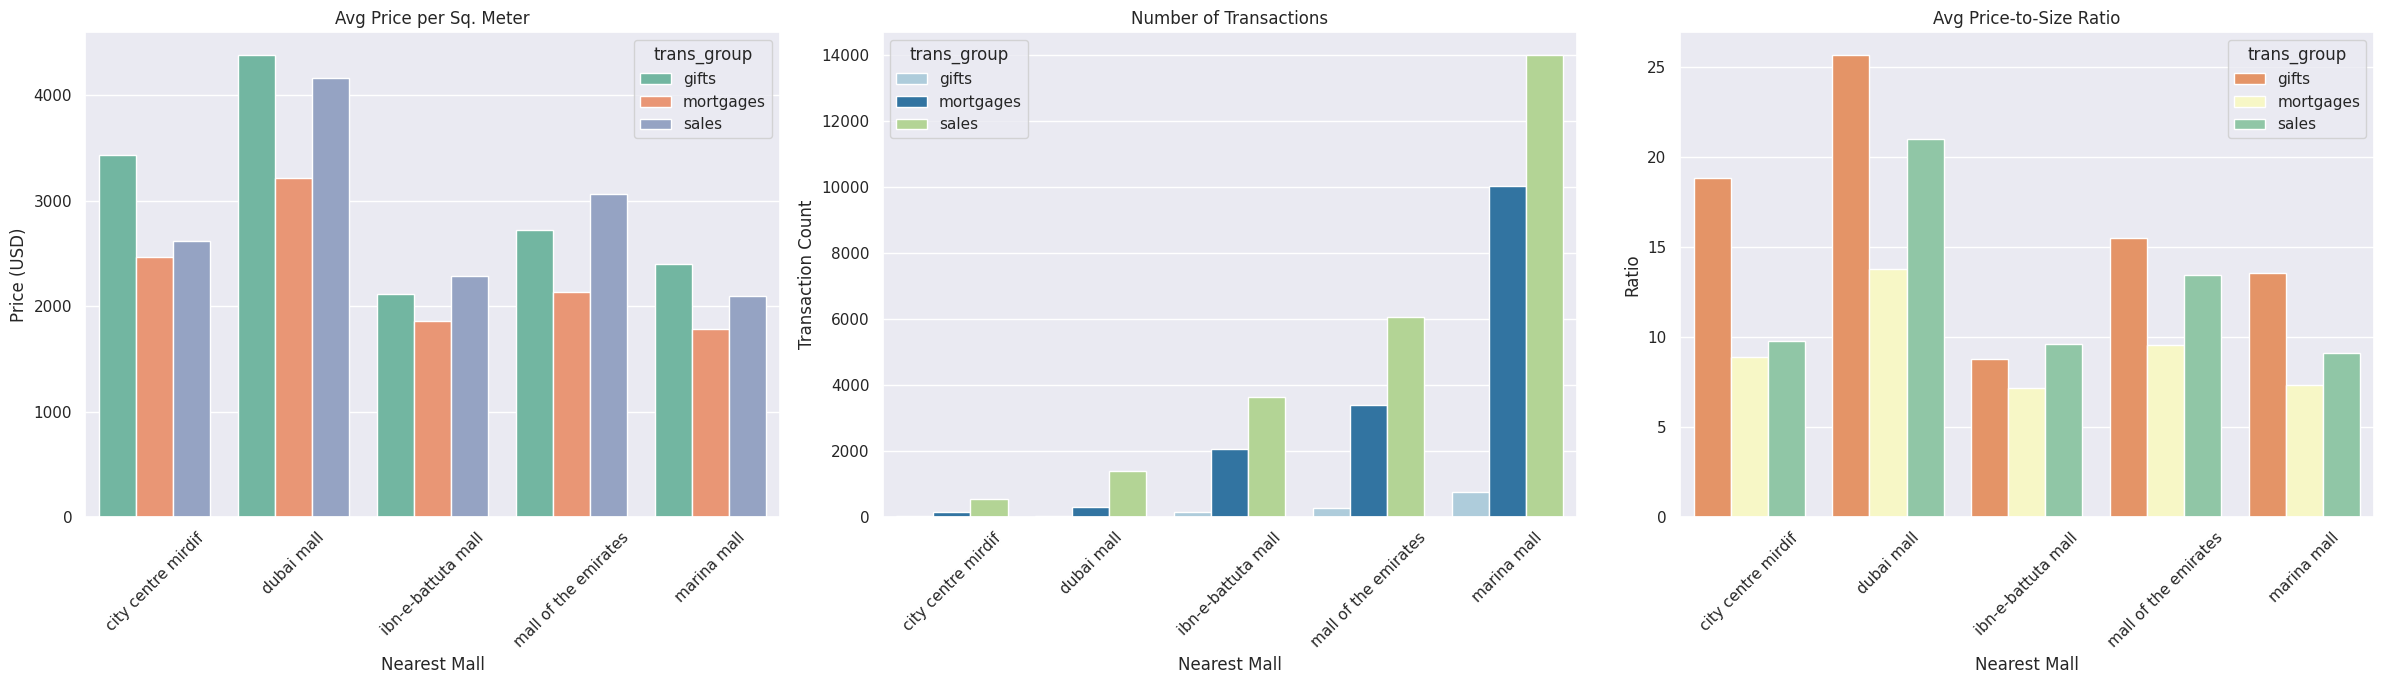

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
plt.subplots_adjust(wspace=0.3)

# Focus on top malls by frequency
top_malls = df_cleaned['nearest_mall'].value_counts().nlargest(10).index
mall_data = df_cleaned[df_cleaned['nearest_mall'].isin(top_malls)]

# 1. Avg Price per Sq Meter
mall_price = (
    mall_data.groupby(['nearest_mall', 'trans_group'])['meter_sale_price_usd']
    .mean().reset_index()
)

sns.barplot(data=mall_price, x='nearest_mall', y='meter_sale_price_usd', hue='trans_group',
            ax=axes[0], palette='Set2')
axes[0].set_title("Avg Price per Sq. Meter")
axes[0].set_ylabel("Price (USD)")
axes[0].set_xlabel("Nearest Mall")
axes[0].tick_params(axis='x', rotation=45)

# 2. Count of Transactions
mall_count = (
    mall_data.groupby(['nearest_mall', 'trans_group'])['transaction_id']
    .count().reset_index().rename(columns={'transaction_id': 'count'})
)

sns.barplot(data=mall_count, x='nearest_mall', y='count', hue='trans_group',
            ax=axes[1], palette='Paired')
axes[1].set_title("Number of Transactions")
axes[1].set_ylabel("Transaction Count")
axes[1].set_xlabel("Nearest Mall")
axes[1].tick_params(axis='x', rotation=45)

# 3. Price-to-Size Ratio
mall_ratio = (
    mall_data.groupby(['nearest_mall', 'trans_group'])['price_to_size_ratio']
    .mean().reset_index()
)

sns.barplot(data=mall_ratio, x='nearest_mall', y='price_to_size_ratio', hue='trans_group',
            ax=axes[2], palette='Spectral')
axes[2].set_title("Avg Price-to-Size Ratio")
axes[2].set_ylabel("Ratio")
axes[2].set_xlabel("Nearest Mall")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

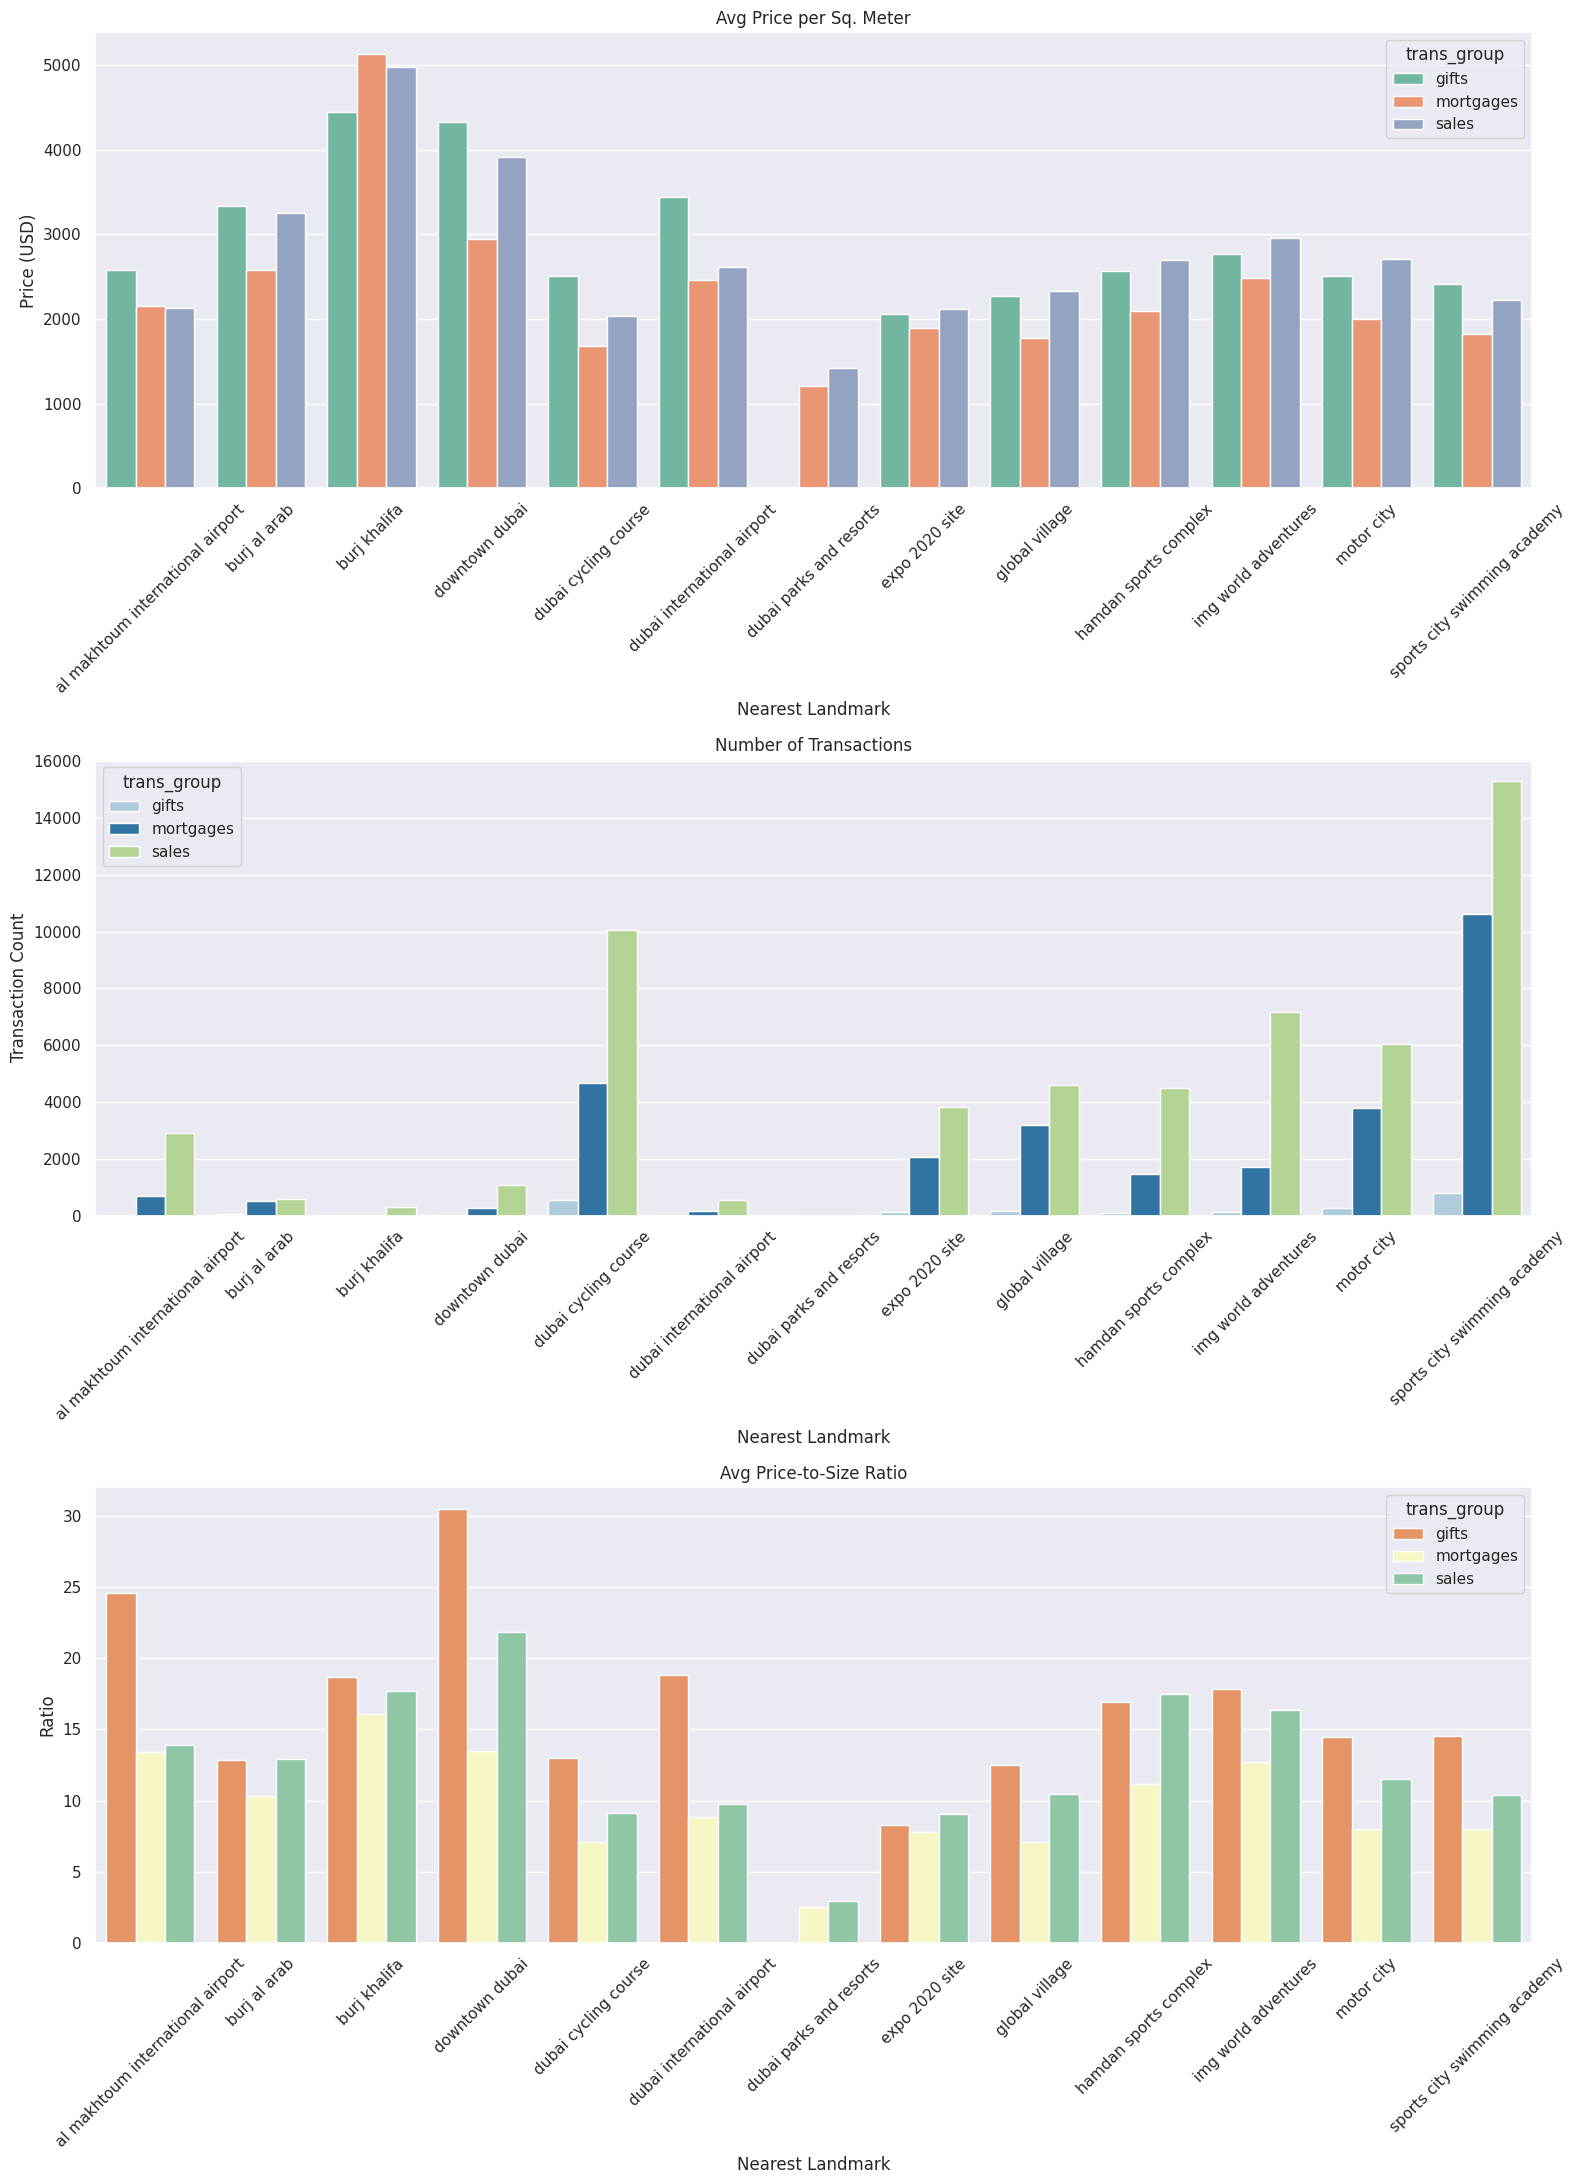

In [39]:
fig, axes = plt.subplots(3, 1, figsize=(16, 22))
plt.subplots_adjust(hspace=0.4)

# Focus on top landmarks by frequency
top_landmarks = df_cleaned['nearest_landmark'].value_counts().nlargest(14).index
landmark_data = df_cleaned[df_cleaned['nearest_landmark'].isin(top_landmarks)]

# 1. Avg Price per Sq Meter
landmark_price = (
    landmark_data.groupby(['nearest_landmark', 'trans_group'])['meter_sale_price_usd']
    .mean().reset_index()
)

sns.barplot(data=landmark_price, x='nearest_landmark', y='meter_sale_price_usd', hue='trans_group',
            ax=axes[0], palette='Set2')
axes[0].set_title("Avg Price per Sq. Meter")
axes[0].set_ylabel("Price (USD)")
axes[0].set_xlabel("Nearest Landmark")
axes[0].tick_params(axis='x', rotation=45)

# 2. Count of Transactions
landmark_count = (
    landmark_data.groupby(['nearest_landmark', 'trans_group'])['transaction_id']
    .count().reset_index().rename(columns={'transaction_id': 'count'})
)

sns.barplot(data=landmark_count, x='nearest_landmark', y='count', hue='trans_group',
            ax=axes[1], palette='Paired')
axes[1].set_title("Number of Transactions")
axes[1].set_ylabel("Transaction Count")
axes[1].set_xlabel("Nearest Landmark")
axes[1].tick_params(axis='x', rotation=45)

# 3. Price-to-Size Ratio
landmark_ratio = (
    landmark_data.groupby(['nearest_landmark', 'trans_group'])['price_to_size_ratio']
    .mean().reset_index()
)

sns.barplot(data=landmark_ratio, x='nearest_landmark', y='price_to_size_ratio', hue='trans_group',
            ax=axes[2], palette='Spectral')
axes[2].set_title("Avg Price-to-Size Ratio")
axes[2].set_ylabel("Ratio")
axes[2].set_xlabel("Nearest Landmark")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

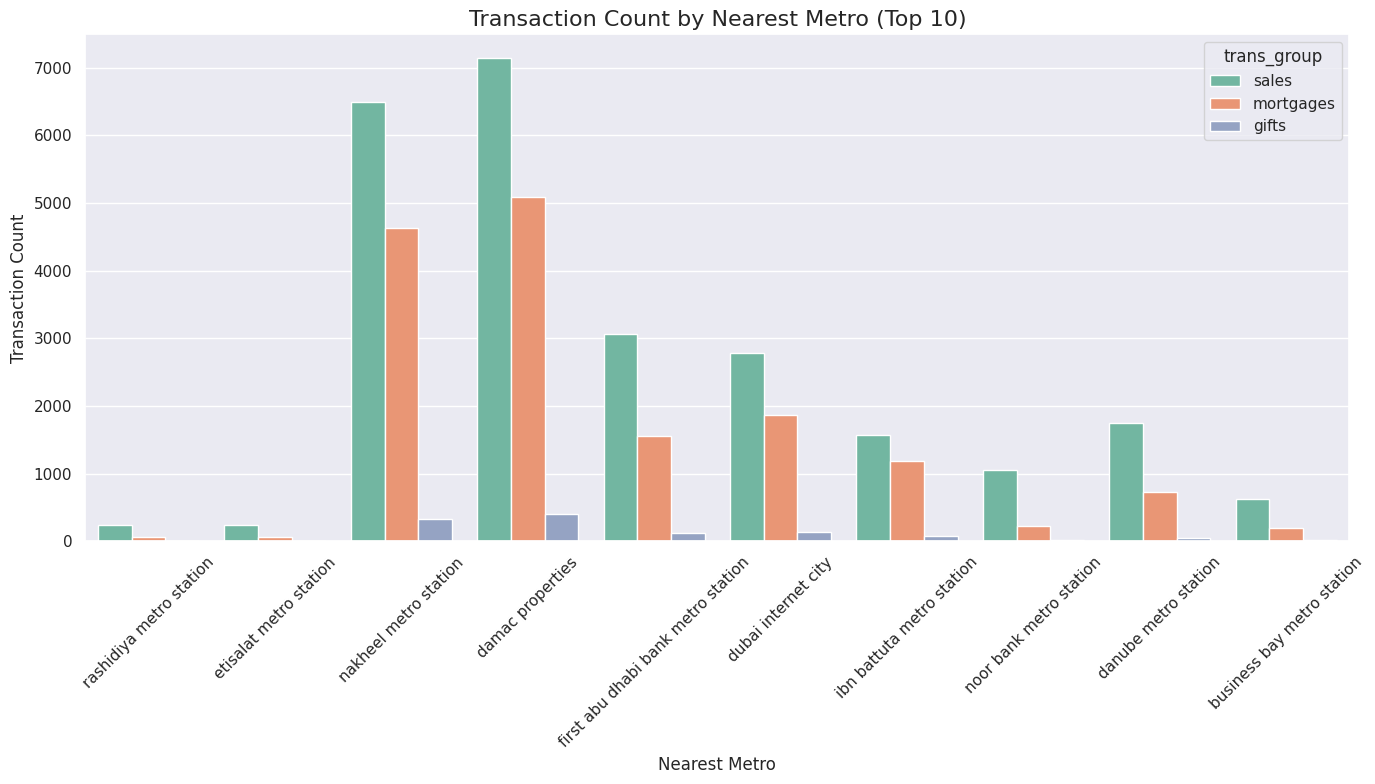

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the top 15 nearest metro stations
top_metros = df_cleaned['nearest_metro'].value_counts().nlargest(10).index
metro_top15 = df_cleaned[df_cleaned['nearest_metro'].isin(top_metros)]

# Plot
plt.figure(figsize=(14, 8))
sns.countplot(data=metro_top15, x='nearest_metro', hue='trans_group', palette='Set2')

plt.title("Transaction Count by Nearest Metro (Top 10)", fontsize=16)
plt.xlabel("Nearest Metro", fontsize=12)
plt.ylabel("Transaction Count", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

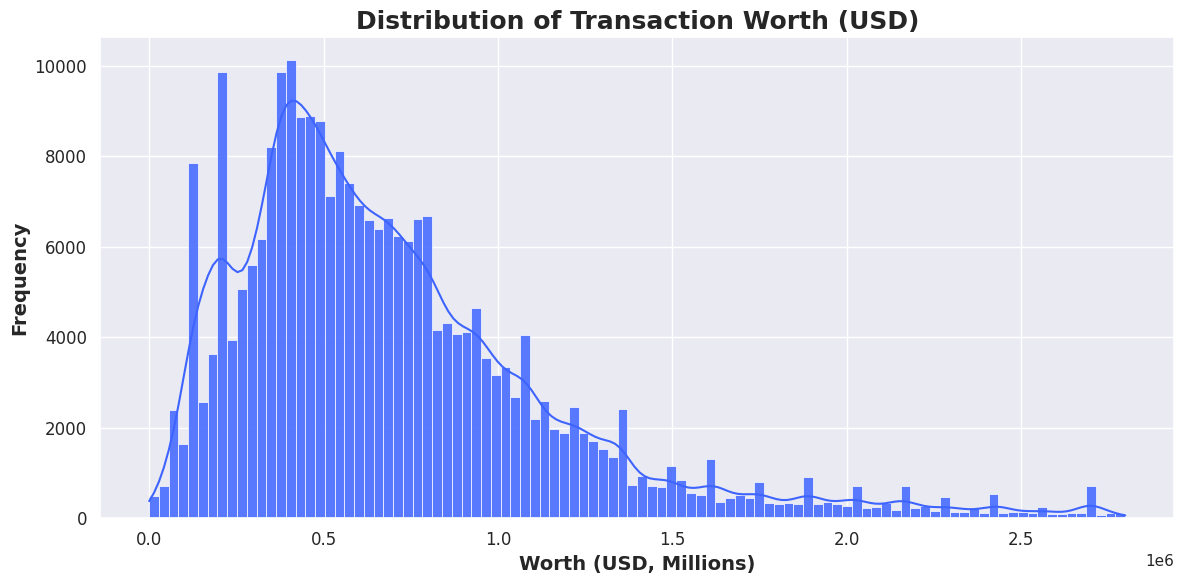

In [41]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(df['actual_worth_usd'], bins=100, kde=True, color='#3E64FF', edgecolor='white', linewidth=0.5, alpha=0.85)

# Custom theme
custom_theme(ax, 'Distribution of Transaction Worth (USD)', 'Worth (USD, Millions)')
plt.tight_layout()
plt.show()

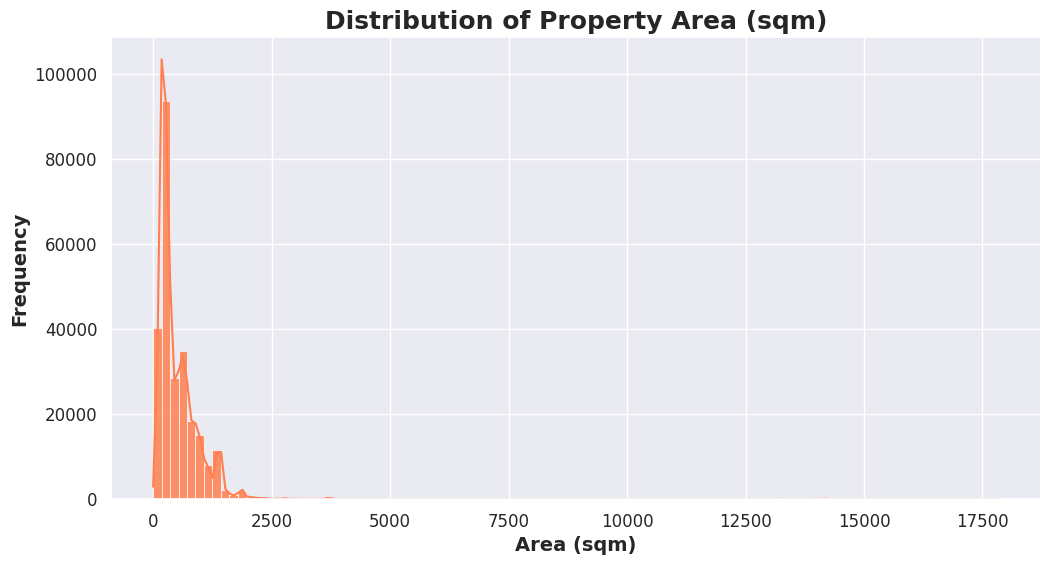

In [42]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(df[df['procedure_area_sqm'] <= 18000]['procedure_area_sqm'], bins=100, kde=True, color='#FF7F50', edgecolor='white', linewidth=0.5, alpha=0.85)

custom_theme(ax, 'Distribution of Property Area (sqm)', 'Area (sqm)')
plt.show()

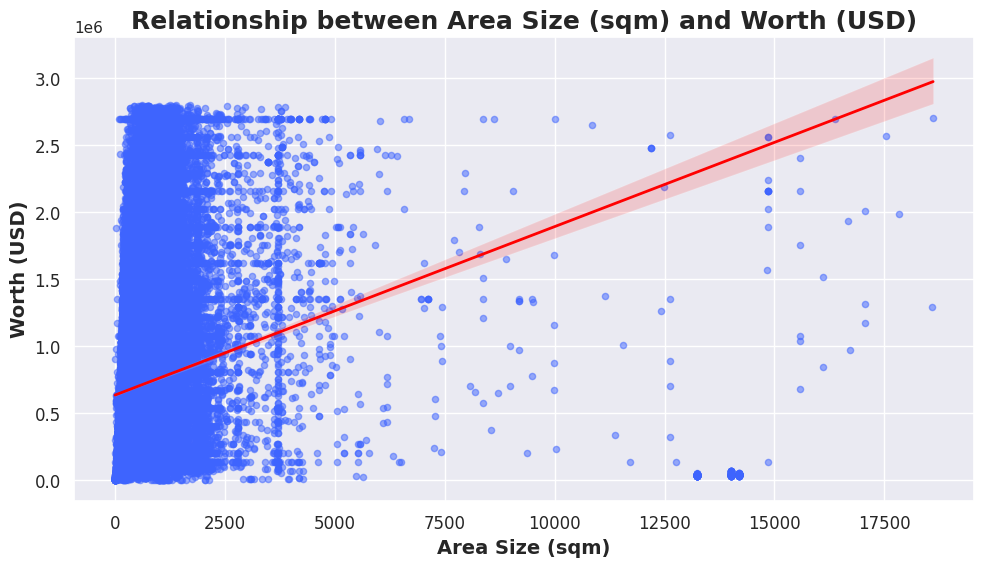

In [46]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(
    data=df[df['procedure_area_sqm']<=20000],
    x='procedure_area_sqm',
    y='actual_worth_usd',
    scatter_kws={'alpha': 0.5, 's': 20, 'color': '#3E64FF'},
    line_kws={'color': 'red', 'linewidth': 2}
)

# Apply your custom theme
custom_theme(ax, 'Relationship between Area Size (sqm) and Worth (USD)', 'Area Size (sqm)', 'Worth (USD)')

plt.tight_layout()
plt.show()

### 2. Time Series Analysis

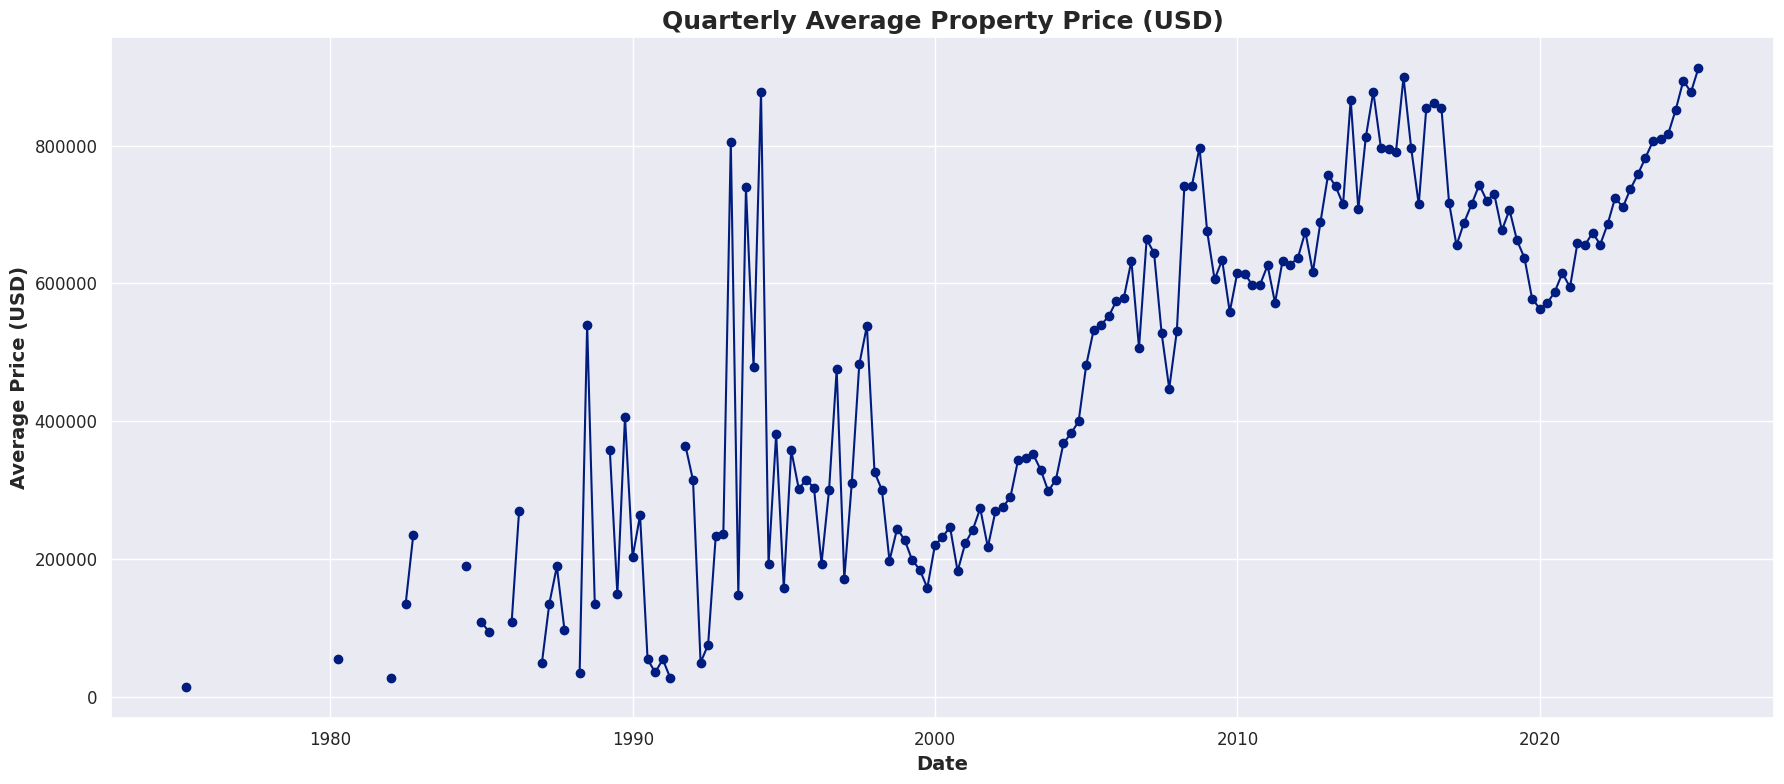

In [48]:
quarterly_prices = df.set_index('instance_date').resample('Q')['actual_worth_usd'].mean()

# Plot
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(quarterly_prices.index, quarterly_prices.values, marker='o')

custom_theme(ax, title='Quarterly Average Property Price (USD)', xlabel='Date', ylabel='Average Price (USD)')

ax.grid(True)
plt.tight_layout()
plt.show()

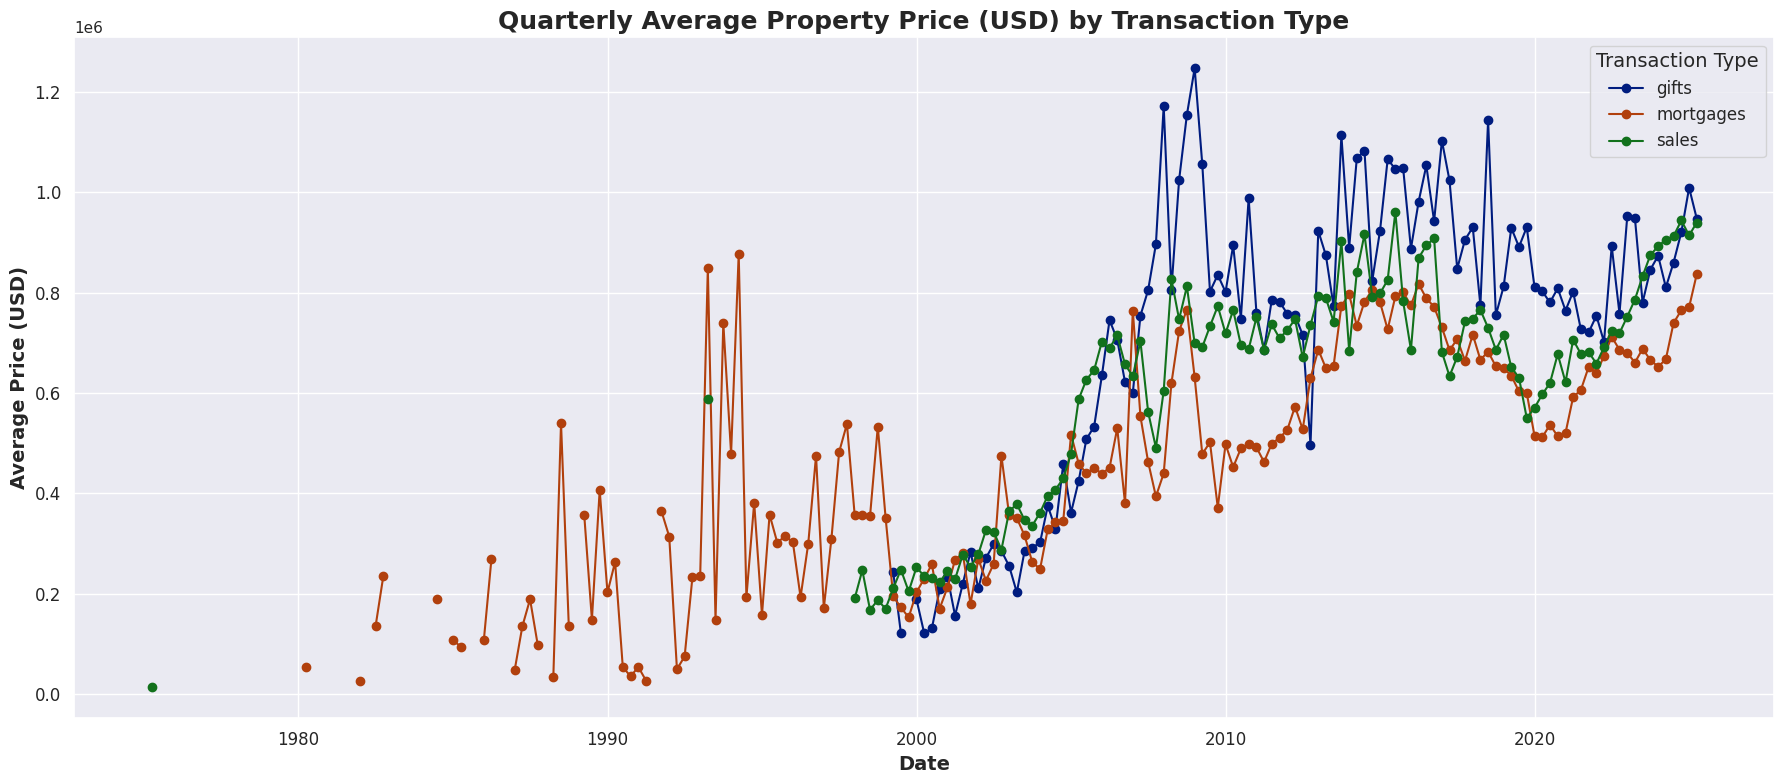

In [49]:
# Group by 'trans_group' and calculate the quarterly average for 'actual_worth_usd'
quarterly_prices_by_type = df.groupby('trans_group').resample('Q', on='instance_date')['actual_worth_usd'].mean().unstack(level=0)

# Plot
fig, ax = plt.subplots(figsize=(18, 8))

# Plot each transaction type on the same graph
for trans_type in quarterly_prices_by_type.columns:
    ax.plot(quarterly_prices_by_type.index, quarterly_prices_by_type[trans_type], marker='o', label=trans_type)

# Apply custom theme for the plot
custom_theme(ax, title='Quarterly Average Property Price (USD) by Transaction Type', xlabel='Date', ylabel='Average Price (USD)')

# Add grid, legend, and adjust layout
ax.grid(True)
ax.legend(title="Transaction Type", fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

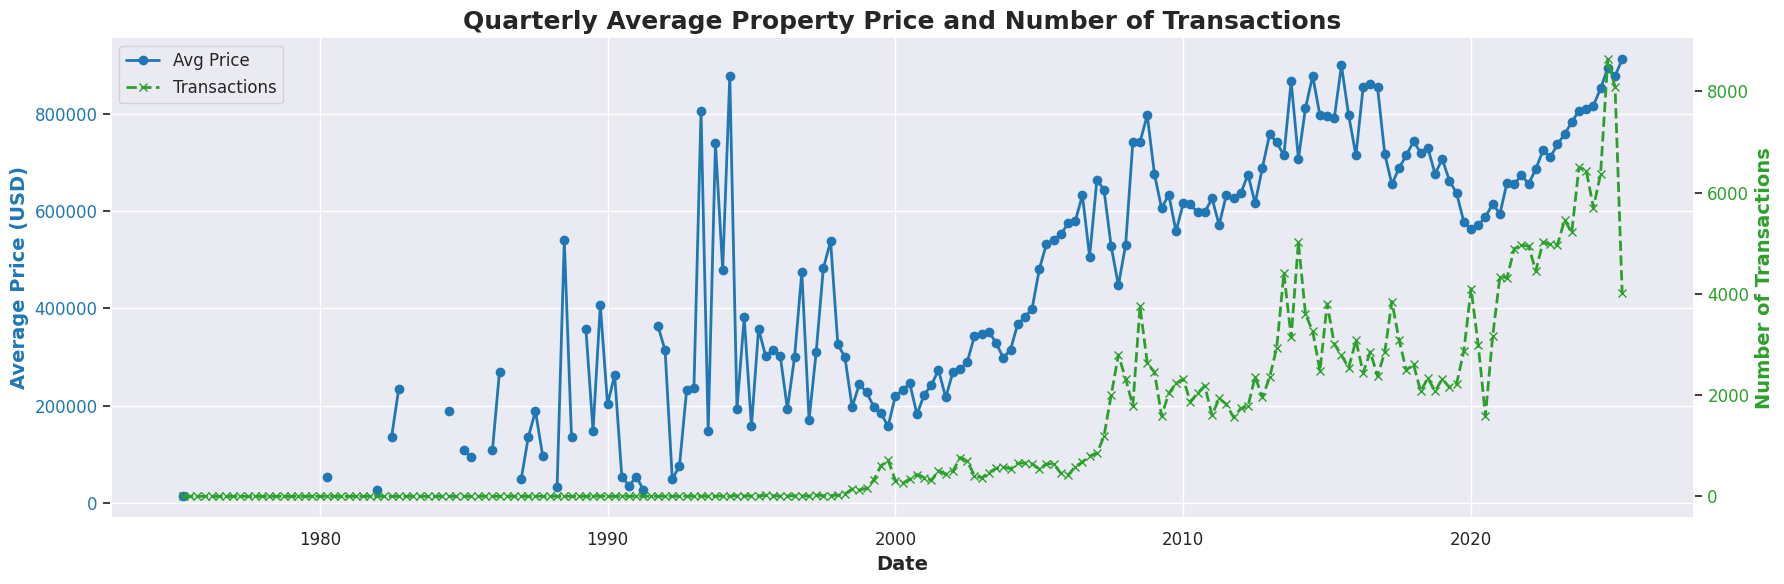

In [50]:
# Resample by quarter
quarterly_prices = df.set_index('instance_date').resample('Q')['actual_worth_usd'].mean()
quarterly_transactions = df.set_index('instance_date').resample('Q').size()

# Plot
fig, ax1 = plt.subplots(figsize=(18, 6))

# First y-axis for average price
color1 = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Price (USD)', color=color1)
ax1.plot(quarterly_prices.index, quarterly_prices.values, color=color1, marker='o', label='Avg Price', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)  # Grid for the first axis

# Apply custom theme to ax1
custom_theme(ax1, title='Quarterly Average Property Price and Number of Transactions', xlabel='Date', ylabel='Average Price (USD)')

# Second y-axis for number of transactions
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('Number of Transactions', color=color2)
ax2.plot(quarterly_transactions.index, quarterly_transactions.values, color=color2, linestyle='--', marker='x', label='Transactions', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)

# Remove grid from ax2 to avoid double grid
ax2.grid(False)

# Apply custom theme to ax2 separately
custom_theme(ax2, title='', xlabel='Date', ylabel='Number of Transactions')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()

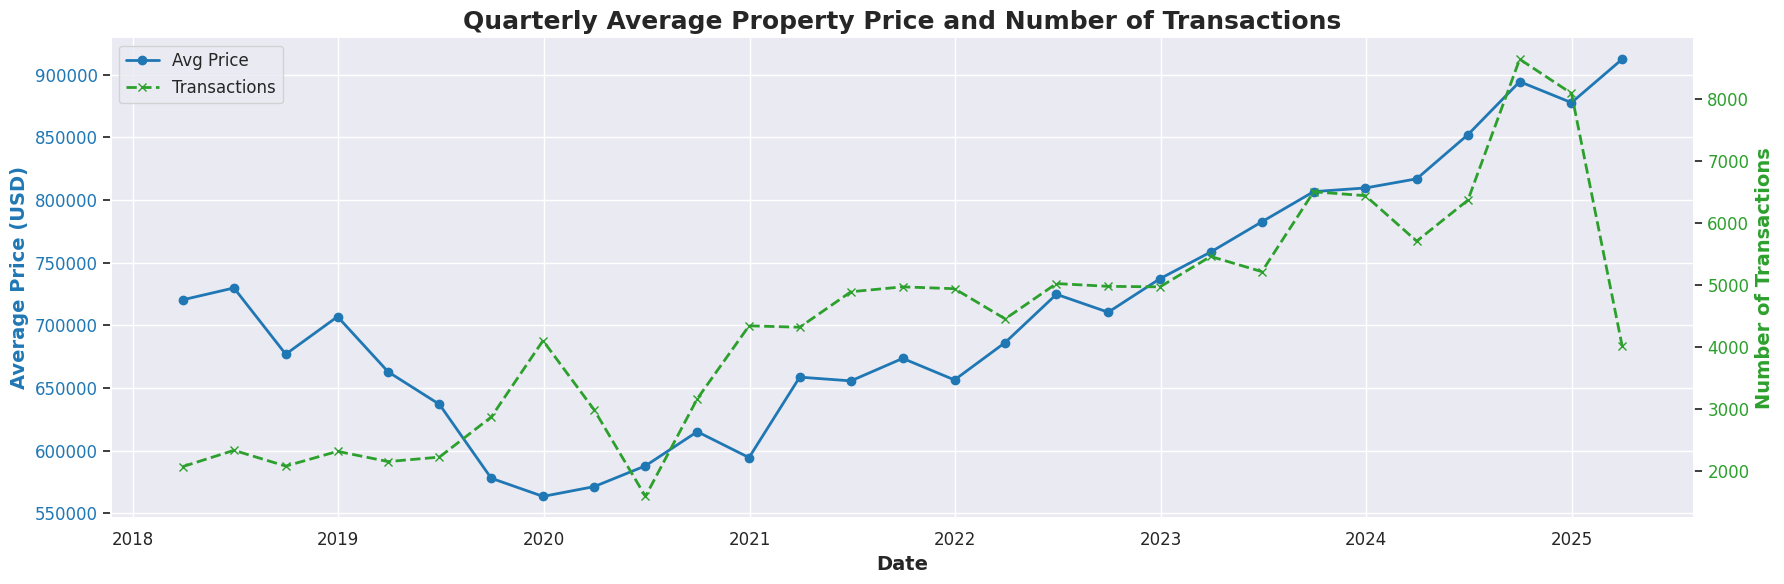

In [51]:
# Resample by quarter
quarterly_prices = df[df['instance_date'].dt.year >= 2018].set_index('instance_date').resample('Q')['actual_worth_usd'].mean()
quarterly_transactions = df[df['instance_date'].dt.year >= 2018].set_index('instance_date').resample('Q').size()

# Plot
fig, ax1 = plt.subplots(figsize=(18, 6))

# First y-axis for average price
color1 = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Price (USD)', color=color1)
ax1.plot(quarterly_prices.index, quarterly_prices.values, color=color1, marker='o', label='Avg Price', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color1)

# Apply custom theme to ax1
custom_theme(ax1, title='Quarterly Average Property Price and Number of Transactions', xlabel='Date', ylabel='Average Price (USD)')

# Second y-axis for number of transactions
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('Number of Transactions', color=color2)
ax2.plot(quarterly_transactions.index, quarterly_transactions.values, color=color2, linestyle='--', marker='x', label='Transactions', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)

# Apply custom theme to ax2 separately
custom_theme(ax2, title='', xlabel='Date', ylabel='Number of Transactions')

# Remove grid from the second axis to avoid double grid
ax1.grid(True)  # Ensure only the first axis has a grid
ax2.grid(False)  # Ensure only the first axis has a grid

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()

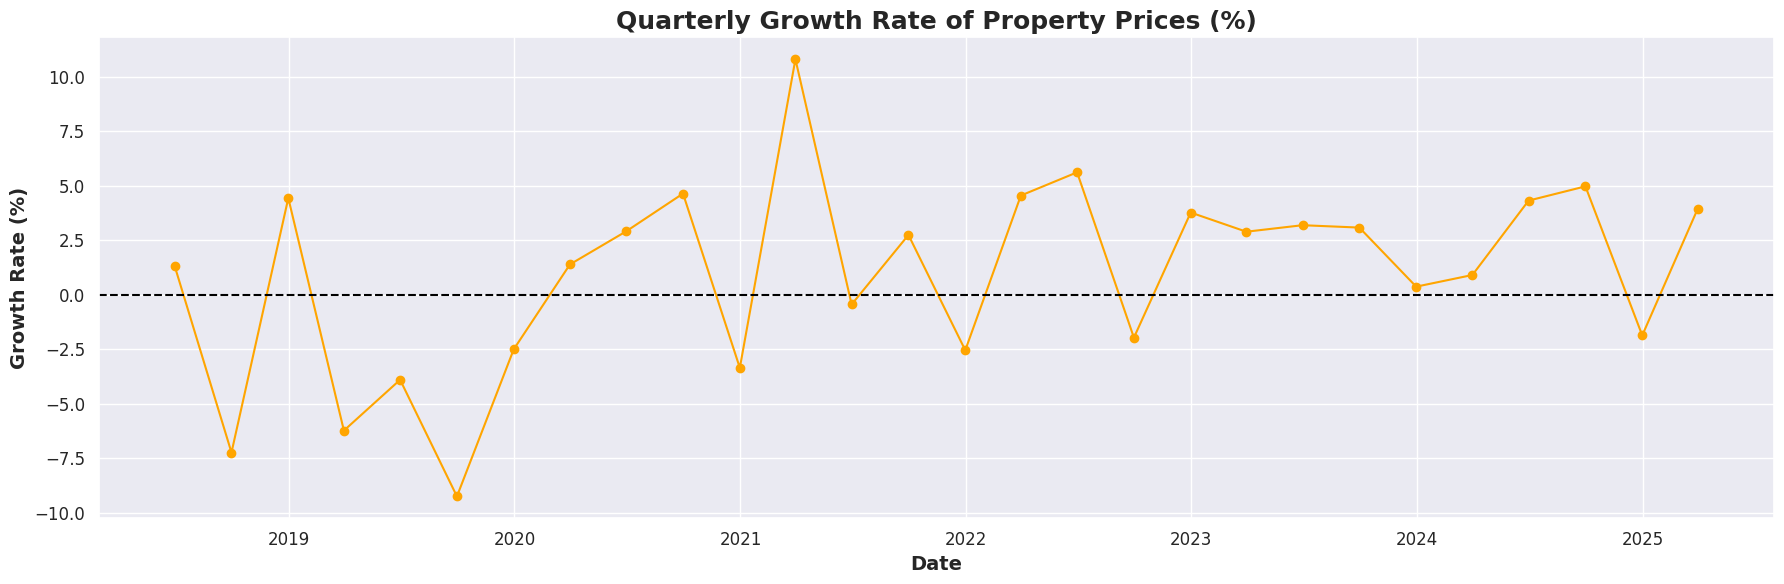

In [52]:
quarterly_growth = quarterly_prices.pct_change() * 100

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(quarterly_growth.index, quarterly_growth.values, marker='o', color='orange')
custom_theme(ax, title='Quarterly Growth Rate of Property Prices (%)', xlabel='Date', ylabel='Growth Rate (%)')
ax.axhline(0, color='black', linestyle='--')
ax.grid(True)
plt.tight_layout()
plt.show()

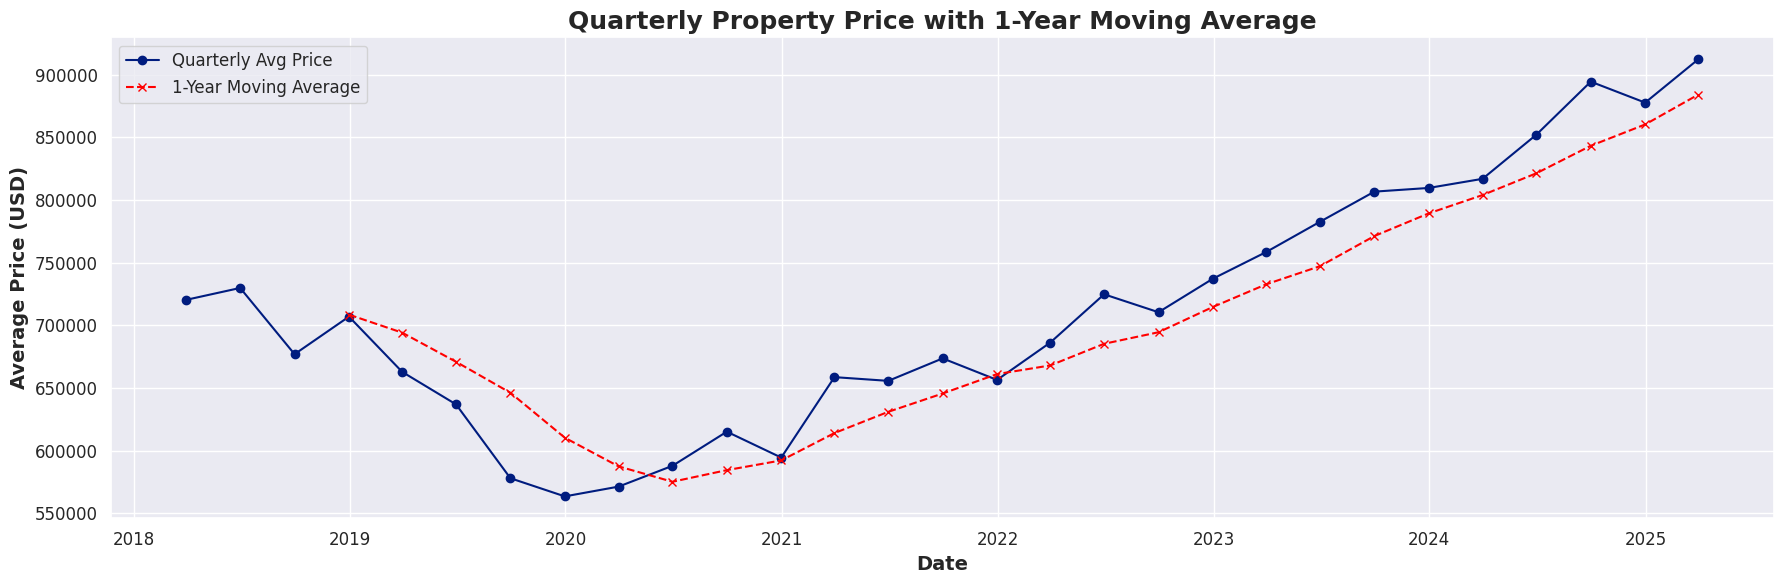

In [53]:
rolling_avg = quarterly_prices.rolling(window=4).mean()  # 4 quarters = 1 year

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(quarterly_prices.index, quarterly_prices.values, marker='o', label='Quarterly Avg Price')
ax.plot(rolling_avg.index, rolling_avg.values, marker='x', linestyle='--', label='1-Year Moving Average', color='red')

custom_theme(ax, title='Quarterly Property Price with 1-Year Moving Average', xlabel='Date', ylabel='Average Price (USD)')
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

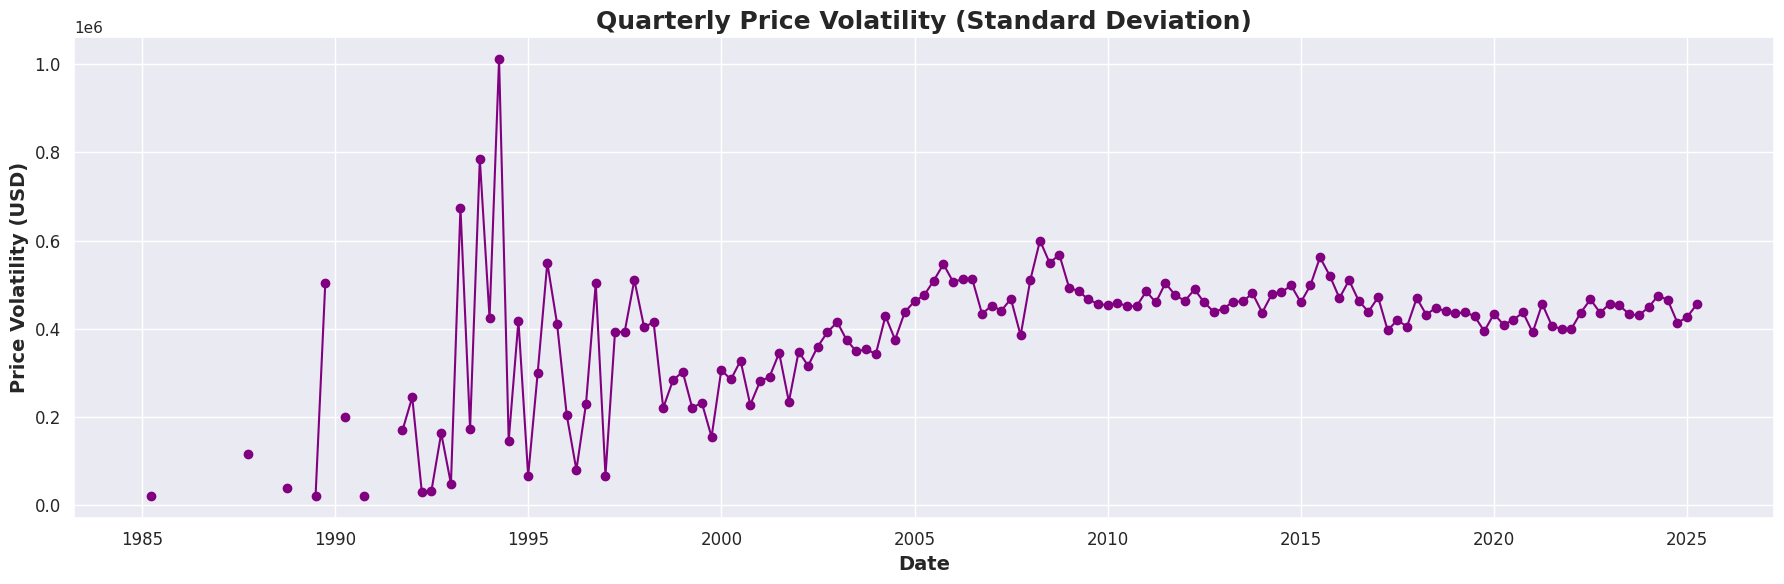

In [54]:
quarterly_std = df.set_index('instance_date').resample('Q')['actual_worth_usd'].std()

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(quarterly_std.index, quarterly_std.values, marker='o', color='purple')
custom_theme(ax, title='Quarterly Price Volatility (Standard Deviation)', xlabel='Date', ylabel='Price Volatility (USD)')
ax.grid(True)
plt.tight_layout()
plt.show()

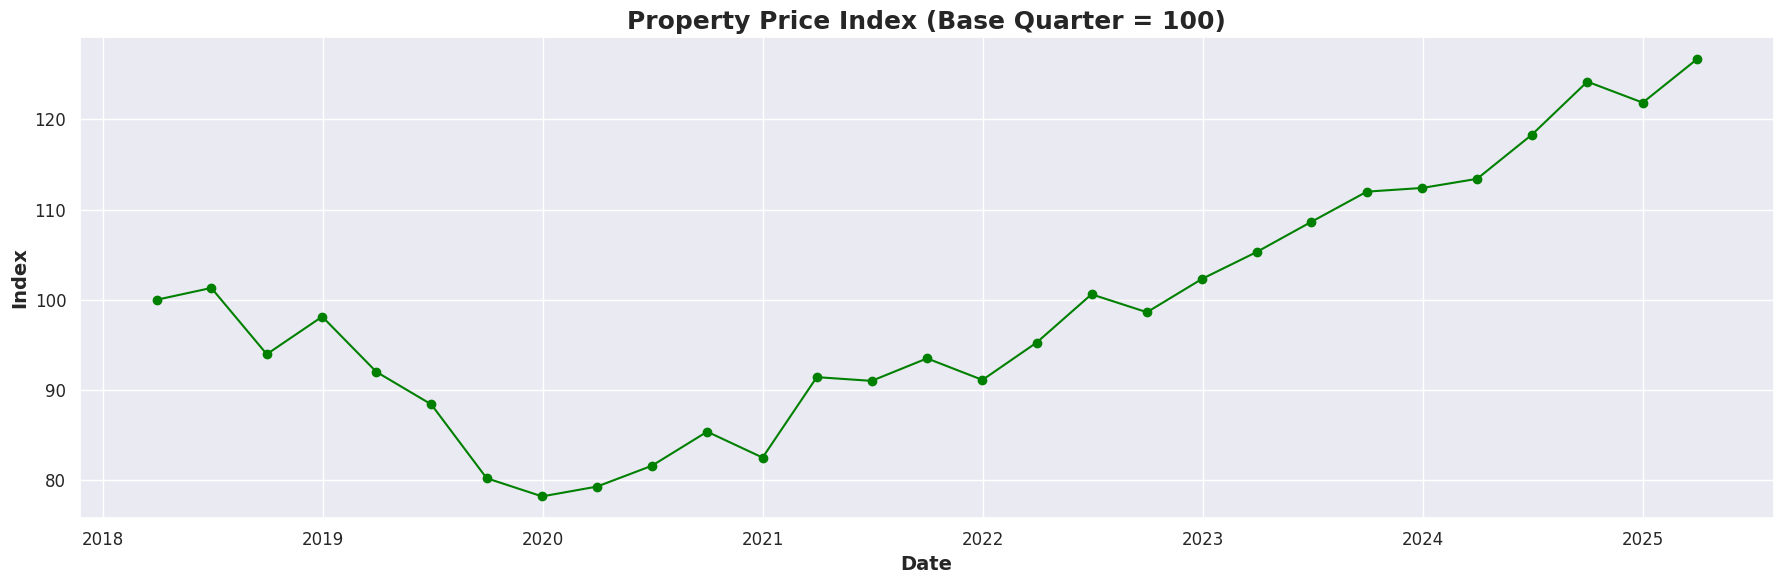

In [55]:
price_index = (quarterly_prices / quarterly_prices.iloc[0]) * 100

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(price_index.index, price_index.values, marker='o', color='green')
custom_theme(ax, title='Property Price Index (Base Quarter = 100)', xlabel='Date', ylabel='Index')
ax.grid(True)
plt.tight_layout()
plt.show()

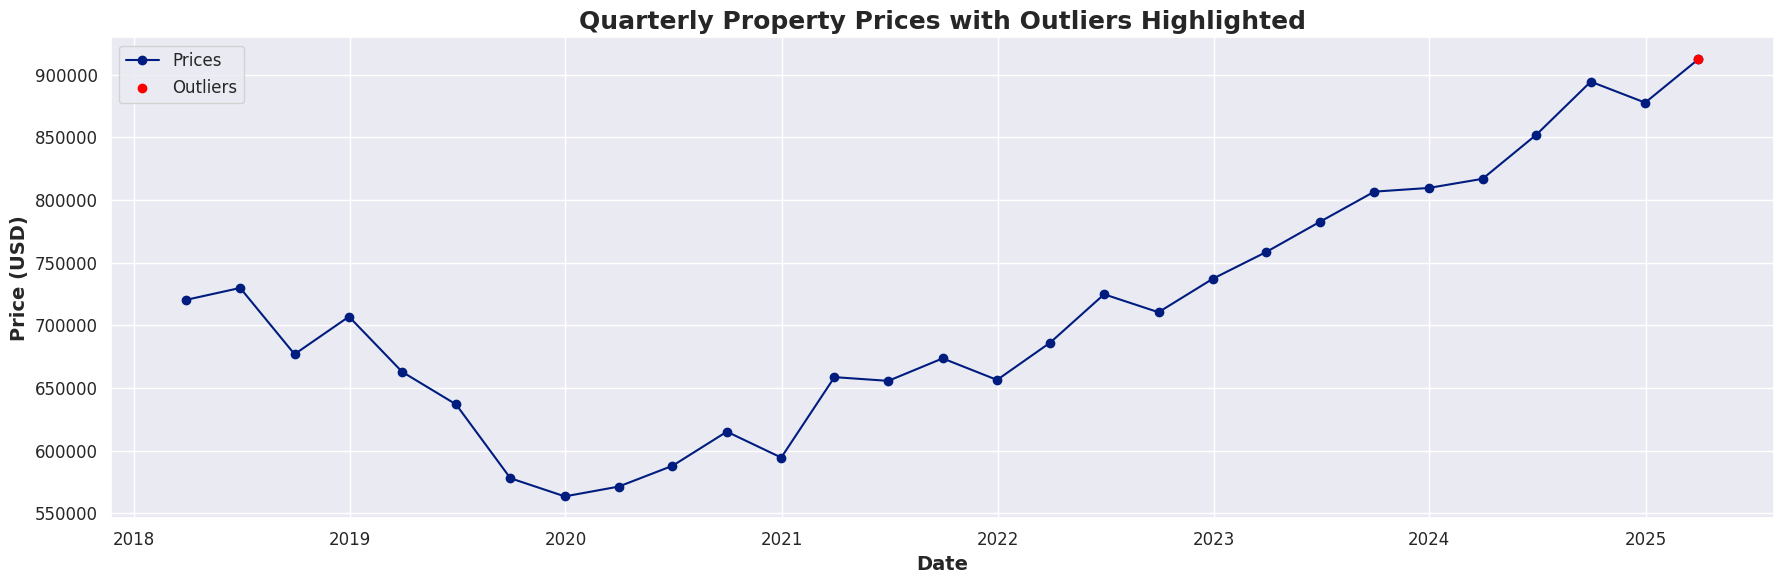

In [56]:
mean = quarterly_prices.mean()
std = quarterly_prices.std()
outliers = quarterly_prices[(quarterly_prices > mean + 2*std) | (quarterly_prices < mean - 2*std)]

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(quarterly_prices.index, quarterly_prices.values, marker='o', label='Prices')
ax.scatter(outliers.index, outliers.values, color='red', label='Outliers', zorder=5)
custom_theme(ax, title='Quarterly Property Prices with Outliers Highlighted', xlabel='Date', ylabel='Price (USD)')
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

### 3. Seasonality Analysis

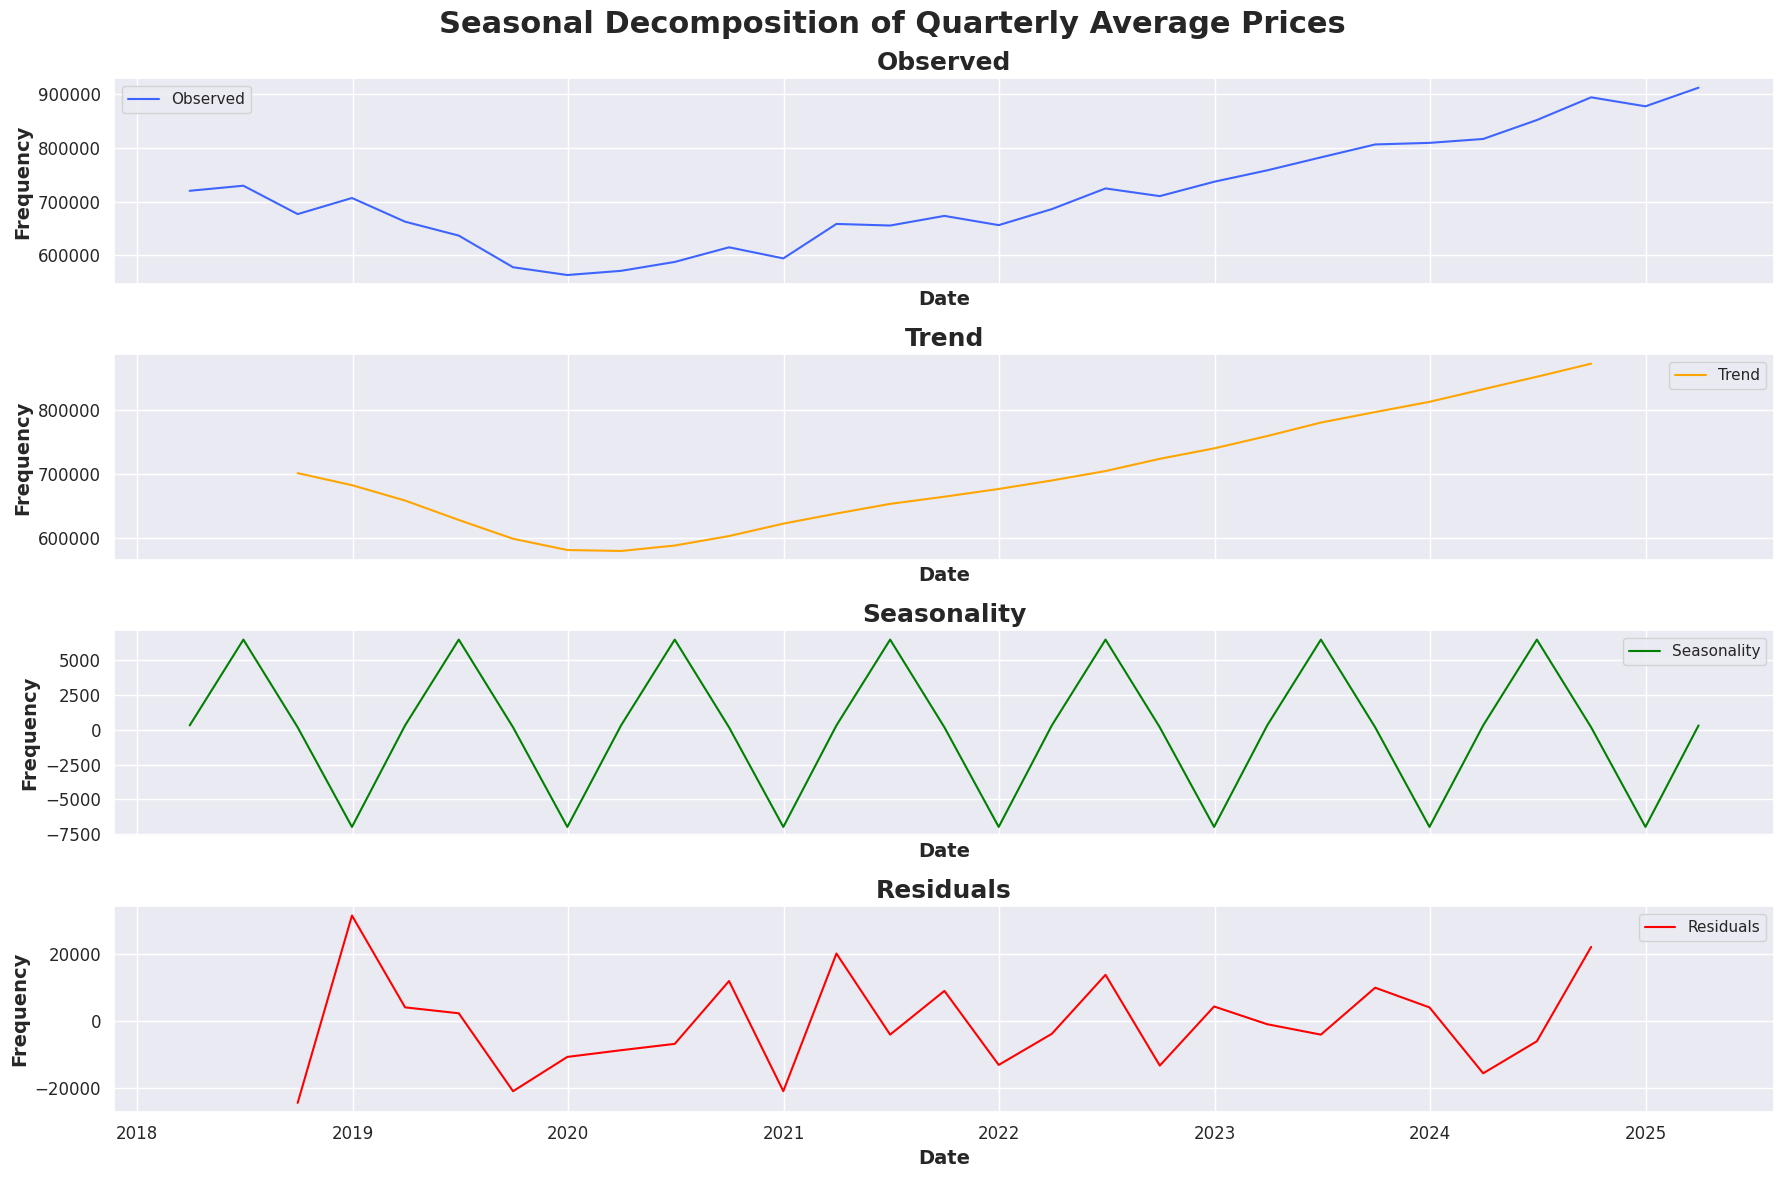

Trend Strength: 0.975
Seasonality Strength: 0.102


In [57]:
# --- Prepare data ---
quarterly_prices = quarterly_prices.dropna()

# --- Seasonal Decomposition ---
decomposition = seasonal_decompose(quarterly_prices, model='additive', period=4)

# --- Plot Decomposition ---
fig, axs = plt.subplots(4, 1, figsize=(18, 12), sharex=True)

titles = ['Observed', 'Trend', 'Seasonality', 'Residuals']
colors = ['#3E64FF', 'orange', 'green', 'red']
components = [decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid]

for ax, title, color, component in zip(axs, titles, colors, components):
    ax.plot(component, label=title, color=color)
    ax.legend()
    custom_theme(ax, title=title, xlabel='Date')

plt.suptitle('Seasonal Decomposition of Quarterly Average Prices', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

# --- Strength Calculations ---
# Remove NaNs from trend, seasonal, and resid components
resid = decomposition.resid.dropna()
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()

# Residual variance
resid_var = np.var(resid)

# Trend strength
trend_var = np.var(trend)
trend_strength = 1 - (resid_var / (resid_var + trend_var))

# Seasonality strength
seasonal_var = np.var(seasonal)
seasonality_strength = 1 - (resid_var / (resid_var + seasonal_var))

# --- Print Results ---
print(f"Trend Strength: {trend_strength:.3f}")
print(f"Seasonality Strength: {seasonality_strength:.3f}")

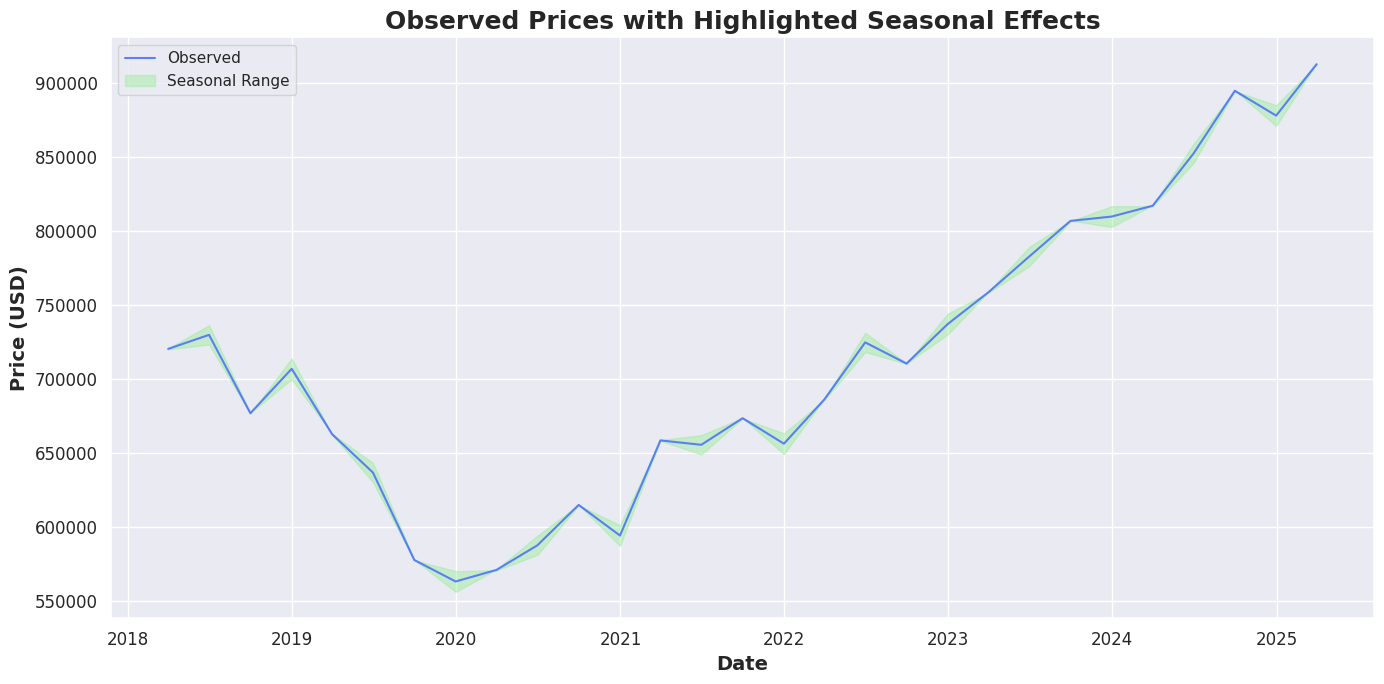

In [59]:
quarterly_prices = quarterly_prices.dropna()

# Seasonal decomposition (specify period=4 for quarterly data)
decomposition = seasonal_decompose(quarterly_prices, model='additive', period=4)

# Retrieve components
observed = decomposition.observed
seasonal = decomposition.seasonal

# Plot observed + seasonal highlight
fig, ax = plt.subplots(figsize=(14, 7))

# Plot observed
ax.plot(observed.index, observed.values, label='Observed', color='#3E64FF', alpha=0.8)

# Overlay seasonal part (as a shaded area)
ax.fill_between(seasonal.index, 
                observed.values - seasonal.values, 
                observed.values + seasonal.values, 
                color='lightgreen', alpha=0.4, label='Seasonal Range')

# Apply your custom theme properly
custom_theme(ax, 
             title='Observed Prices with Highlighted Seasonal Effects', 
             xlabel='Date', 
             ylabel='Price (USD)')

# Legend
ax.legend()

plt.tight_layout()
plt.show()